In [12]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from pandas_ml_quant import np, pd

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
df = pd.read_csv('../pandas_ml_quant_test/.data/SPY.csv', parse_dates=True, index_col='Date')
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-11-29,314.859985,315.130005,314.059998,314.309998,314.309998,36592700
2019-12-02,314.589996,314.660004,311.170013,311.640015,311.640015,75767800
2019-12-03,308.649994,309.640015,307.130005,309.549988,309.549988,73941700
2019-12-04,310.700012,312.119995,310.320007,311.459991,311.459991,49080000
2019-12-05,312.230011,312.250000,310.580109,312.089996,312.089996,40781669


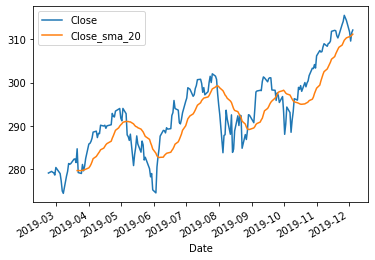

In [14]:
df["Close"].ta.sma(20)
df[-200:]._[["Close", lambda df: df["Close"].ta.sma(20)]].plot()

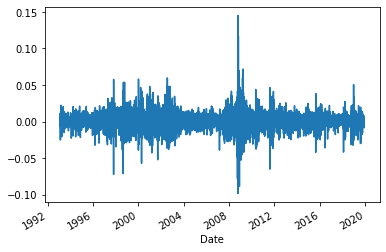

In [15]:
df["Close"].ta.returns().plot()

In [20]:
with df.model() as m:
    from sklearn.neural_network import MLPRegressor
    from pandas_ml_utils import PostProcessedFeaturesAndLabels, SkModel, FittingParameter
    from pandas_ml_quant import PricePredictionSummary
    from pandas_ml_utils.constants import *

    model = SkModel(
        MLPRegressor(10, activation='identity', learning_rate_init=0.1, max_iter=5000, validation_fraction=0, warm_start=True),
        PostProcessedFeaturesAndLabels(
            features=[
                lambda df: df["Close"].ta.returns(),
                lambda df: df["Close"].ta.rsi(),  # Adding this makes the error better but all the other metrics worse
            ],
            feature_post_processor=[
                lambda df: df.ta.rnn(30)
            ],
            labels=[
                lambda df: df["Close"].ta.returns().shift(-1)
            ]
        ),
        PricePredictionSummary.with_reconstructor(
            lambda y: (1 + y).cumprod(),
            lambda df: (1 + df[LABEL_COLUMN_NAME]).cumprod().shift(1) * (1 + df[PREDICTION_COLUMN_NAME])
        )
    )

    fit = m.fit(
        model,
        FittingParameter(epochs=100)
    )

fit

In [21]:
df[-200:].model.backtest(fit.model)


,mse,Direction Correct Ratio,Correlation,r^2
0,0.000163,0.288462,-0.084993,-1.379543
